In [1]:
import seaborn as sns
sns.set()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Question 1

Given some sample data, write a program to answer the following:

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
What metric would you report for this dataset?
What is its value?


**Short Answer:** The naive measure that was calculated was just a mean of the total order amounts. Instead, we should calculate the total order amount divided by the total number of orders. And, there are two issues with the data set: (1) shop with id number 78 has been entering order amount by missing comma, which leads to order amounts looking like 100 times larger than usual. (2) shop with id number 42 has enormous order amounts that look like credit card fraud.

Once we solve these issues, AOV becomes $\$152.62$.

**Long Answer and Analysis:**

In [3]:
df = pd.read_csv("2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")

In [4]:
df[["order_amount","total_items"]].describe(percentiles=[0.05,0.5,0.95])

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
5%,122.000000,1.00000
50%,284.000000,2.00000
95%,640.000000,4.00000
max,704000.000000,2000.00000


From this summary of order amount, we can see that the naive measure for AOV was just the mean of order_amount. However, AOV should measure the average dollar amount spent each time a customer places an order. To calculate the average order value, simply divide total order amount by the number of orders:

In [5]:
df["order_amount"].sum() / df["total_items"].sum()

357.92152221412965

This number is still high since the shops sell shoes. As we see from summary statistics, there are some issues with our data points. Let's create the item's price for each order and look at the summary statistics.

In [6]:
df["item_price"] = df["order_amount"] / df["total_items"]

In [7]:
df[["order_amount","total_items","item_price"]].describe(percentiles=[0.05,0.5,0.95])

,order_amount,total_items,item_price
count,5000.000000,5000.00000,5000.000000
mean,3145.128000,8.78720,387.742800
std,41282.539349,116.32032,2441.963725
min,90.000000,1.00000,90.000000
5%,122.000000,1.00000,112.000000
50%,284.000000,2.00000,153.000000
95%,640.000000,4.00000,195.000000
max,704000.000000,2000.00000,25725.000000


There are some shoes that are sold for $\$$25725!!

Let's identify "abnormal" or out-of-the-ordinary data points (outliers) and see if they are "technical glitches" that we can correct.

Since our data set possibly includes outliers, we will perform **outlier detection.**

In Scikit-learn, it is implemented as **unsupervised learning** methods. Common algorithms include **One-class SVM** and **Isolation Forests.** 

Isolation Forest (iForest) is a newer and more efficient method, especially for high-dimensional data sets.

Isolation Forest exploits two characteristics of anomalous observations: they are relatively few in number, and they are very different from "normal" values (Liu, Ting, and Zhou, 2008). An isolation forest aims to "isolate" the outliers based on these two facts, using an ensemble of classification trees.

### Isolation Forest in Scikit-learn

In [8]:
from sklearn.ensemble import IsolationForest

X = df[["total_items", "order_amount", "item_price"]]
clf = IsolationForest(random_state=1001)
clf.fit(X)

y_pred = clf.predict(X)

float(sum(y_pred==-1))/len(y_pred) # proportion of outliers 

0.1022

This model labels $10\%$ of the observations as outliers. To understand why, it can help to look at the decision function. These scores are a non-linear function of the path-length metric and can take values between  −0.5  and  0.5.

In [9]:
df["anomaly_score"] = clf.decision_function(X)
df["anomaly_score_sign"] = y_pred
df["anomaly_score"]

0       0.055297
1      -0.101206
2       0.093194
3       0.101823
4       0.101823
          ...   
4995    0.112074
4996    0.066716
4997    0.025723
4998    0.103203
4999    0.116164
Name: anomaly_score, Length: 5000, dtype: float64

Higher values are less anomalous and lower values are more anomalous. Let's check the relation between the anomaly scores and the price of items.

<AxesSubplot:xlabel='item_price', ylabel='anomaly_score'>

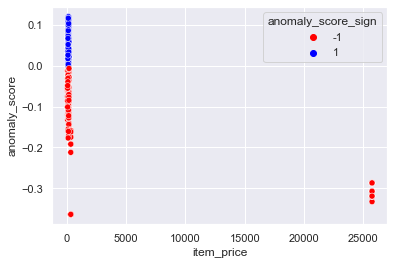

In [10]:
sns.scatterplot(data=df, x='item_price', y='anomaly_score', hue='anomaly_score_sign',  palette=["red", "blue"])

<AxesSubplot:xlabel='total_items', ylabel='anomaly_score'>

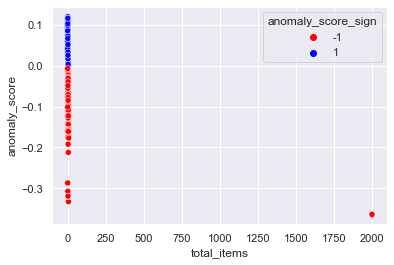

In [11]:
sns.scatterplot(data=df, x='total_items', y='anomaly_score', hue='anomaly_score_sign',  palette=["red", "blue"])

More anomalous observations consists of orders with high item price tags and some with normal price tag. Let's check such points to understand why it is the case. We can do it by inspecting the most anomolus observations.

In [12]:
df.sort_values(by=["anomaly_score"]).head(35)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_price,anomaly_score,anomaly_score_sign
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0,-0.364013,-1
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0,-0.364013,-1
4868,4869,42,607,704000,2000,credit_card,2017-03-22 4:00:00,352.0,-0.364013,-1
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,352.0,-0.364013,-1
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0,-0.364013,-1
4882,4883,42,607,704000,2000,credit_card,2017-03-25 4:00:00,352.0,-0.364013,-1
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0,-0.364013,-1
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,352.0,-0.364013,-1
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,352.0,-0.364013,-1
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0,-0.364013,-1


From the table below, we realize that shops 42 and 78 have an unusually high price tag or a large number of total items, which dramatically affects the AOV by skewing the mean upwards.

Let's first inspect the observations with a price higher or equal to $\$$352:

In [13]:
df[df.item_price>=352]["shop_id"].unique()

array([42, 78], dtype=int64)

Let's inspect the observations with larger or equal to 2000 order amounts:

In [14]:
df[df.total_items>=2000]["shop_id"].unique()

array([42], dtype=int64)

They are all from the same shop. Let's look at the summay statistics of shop 78 and 42, seperately.

In [15]:
outlier_shop_1 = df[df.shop_id==78]
outlier_shop_1[["order_amount","total_items","item_price"]].describe()

,order_amount,total_items,item_price
count,46.000000,46.000000,46.0
mean,49213.043478,1.913043,25725.0
std,26472.227449,1.029047,0.0
min,25725.000000,1.000000,25725.0
25%,25725.000000,1.000000,25725.0
50%,51450.000000,2.000000,25725.0
75%,51450.000000,2.000000,25725.0
max,154350.000000,6.000000,25725.0


In [16]:
outlier_shop_2 = df[df.shop_id==42]
outlier_shop_2[["order_amount","total_items","item_price"]].describe()

,order_amount,total_items,item_price
count,51.000000,51.000000,51.0
mean,235101.490196,667.901961,352.0
std,334860.641587,951.308641,0.0
min,352.000000,1.000000,352.0
25%,352.000000,1.000000,352.0
50%,704.000000,2.000000,352.0
75%,704000.000000,2000.000000,352.0
max,704000.000000,2000.000000,352.0


We find our problems:

(1) Every observation related to shop 78 very high price tag. 

The possible problem is entering the order amount by missing a comma, making order amounts look 100 times larger than usual. This is the case for shop 78. 

(2) The observations with 2000 order amounts look like credit card fraud: they were all created at the same time of the day with the same and larger order size.

Let's correct these issues and then calculate the AOV.

In [17]:
df.loc[df.shop_id ==78, 'order_amount'] = df.loc[df.shop_id ==78, 'order_amount'] / 100

In [18]:
df = df[df.order_amount < 2000]

In [19]:
df["item_price"] = df["order_amount"] / df["total_items"]

In [20]:
df[["order_amount","total_items","item_price"]].describe(percentiles=[0.05,0.5,0.95])

,order_amount,total_items,item_price
count,4983.000000,4983.00000,4983.000000
mean,304.330323,1.99398,152.762091
std,163.037187,0.98318,30.609596
min,90.000000,1.00000,90.000000
5%,122.000000,1.00000,112.000000
50%,284.000000,2.00000,153.000000
95%,595.600000,4.00000,193.000000
max,1760.000000,8.00000,352.000000


The summary statistics look normal after solving the two issues. Let's also do a final check with Isolation Forest and plotting.

In [21]:
X2 = df[["total_items", "order_amount", "item_price"]]
clf = IsolationForest(random_state=1001)
clf.fit(X)

y_pred2 = clf.predict(X2)

float(sum(y_pred2==-1))/len(y_pred2) # proportion of outliers 

0.09913706602448324

In [22]:
df["anomaly_score"] = clf.decision_function(X2)

<AxesSubplot:xlabel='total_items', ylabel='order_amount'>

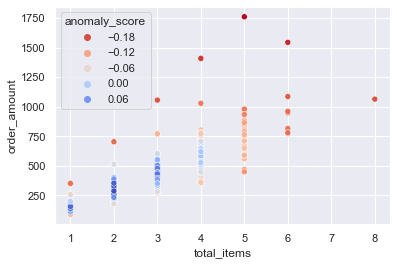

In [23]:
sns.scatterplot(data=df, x='total_items', y='order_amount', hue='anomaly_score', palette="coolwarm_r")

In [24]:
df.sort_values(by=["anomaly_score"]).head(20)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_price,anomaly_score,anomaly_score_sign
1364,1365,42,797,1760.0,5,cash,2017-03-10 6:28:21,352.00,-0.212260,-1
691,692,78,878,1543.5,6,debit,2017-03-27 22:51:43,257.25,-0.199457,-1
1367,1368,42,926,1408.0,4,cash,2017-03-13 2:38:34,352.00,-0.192124,-1
1471,1472,42,907,1408.0,4,debit,2017-03-12 23:00:22,352.00,-0.192124,-1
4141,4142,54,733,1064.0,8,debit,2017-03-07 17:05:18,133.00,-0.177068,-1
2987,2988,42,819,1056.0,3,cash,2017-03-03 9:09:25,352.00,-0.174988,-1
938,939,42,808,1056.0,3,credit_card,2017-03-13 23:43:45,352.00,-0.174988,-1
3513,3514,42,726,1056.0,3,debit,2017-03-24 17:51:05,352.00,-0.174988,-1
3538,3539,43,830,1086.0,6,debit,2017-03-17 19:56:29,181.00,-0.170919,-1
835,836,42,819,704.0,2,cash,2017-03-09 14:15:15,352.00,-0.161993,-1


It passes both inspections! The AOV becomes:

In [25]:
df["order_amount"].sum() / df["total_items"].sum()

152.62459742351047

# Question 2

For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL
Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

How many orders were shipped by Speedy Express in total? **54**

What is the last name of the employee with the most orders? **Peacock**

What product was ordered the most by customers in Germany? **Boston Crab Meat**

``` mysql
SELECT COUNT(*)
FROM ORDERS as t1
JOIN SHIPPERS as t2
ON t1.shipperid = t2.shipperid
WHERE shippername="Speedy Express"
```

``` mysql
SELECT t1.employeeid, t2.lastname, COUNT(*) NumOrders
FROM ORDERS as t1
JOIN EMPLOYEES as t2
ON t1.employeeid = t2.employeeid
GROUP BY t1.employeeid
ORDER BY NumOrders DESC
```

``` mysql
SELECT productname, SUM(t3.quantity) TotalQuantities
FROM ORDERS as t1
JOIN CUSTOMERS as t2
ON t1.customerid = t2.customerid
JOIN ORDERDETAILS as t3
ON t1.orderid = t3.orderid
JOIN PRODUCTS as t4
ON t3.productid = t4.productid
WHERE country = "Germany"
GROUP BY t3.productid
ORDER BY TotalQuantities DESC
LIMIT 1
```